## Code for different starting positions

In [1]:
import random

class Circle:
    def __init__(self, x, y, radius):
        self.x = x
        self.y = y
        self.radius = radius

circles = [] 
while len(circles) < 10:
    x = random.randint(0, 100)
    y = random.randint(0, 100)
    radius = random.randint(5, 20)
    circle = Circle(x, y, radius)
    if all(((circle.x, circle.y, circle.radius) != (c.x, c.y, c.radius)) for c in circles):
        circles.append(circle)

# Display circles
for circle in circles:
    print(f"Circle at ({circle.x}, {circle.y}) with radius {circle.radius}")


Circle at (71, 2) with radius 19
Circle at (11, 89) with radius 14
Circle at (49, 60) with radius 20
Circle at (39, 60) with radius 7
Circle at (80, 26) with radius 20
Circle at (66, 68) with radius 7
Circle at (81, 23) with radius 20
Circle at (13, 65) with radius 5
Circle at (64, 57) with radius 20
Circle at (87, 28) with radius 14


## Class definitions
In this code, we removed the particle-particle collision portion of the code so it only accounts for particle-wall collision. This is to simulate for the small amounts of gas particles in a big area due to the almost negligible likelihood of the particles colliding. However, the resultant distribution graph will not follow the Maxwell-Boltzmann distribution.

In [2]:
import numpy as np
%matplotlib notebook



class Particle:
    """Define physics of elastic collision."""
    
    def __init__(self, mass, radius, position, velocity):
        """Initialize a Particle object
        
        mass the mass of particle
        radius the radius of particle
        position the position vector of particle
        velocity the velocity vector of particle
        """
        self.mass = mass
        self.radius = radius
        
        # last position and velocity
        self.position = np.array(position)
        self.velocity = np.array(velocity)
        
        # all position and velocities recorded during the simulation
        self.solpos = [np.copy(self.position)]
        self.solvel = [np.copy(self.velocity)]
        self.solvel_mag = [np.linalg.norm(np.copy(self.velocity))]
        
    def compute_step(self, step):
        """Compute position of next step."""
        self.position += step * self.velocity
        self.solpos.append(np.copy(self.position)) 
        self.solvel.append(np.copy(self.velocity)) 
        self.solvel_mag.append(np.linalg.norm(np.copy(self.velocity))) 
        

###########################################################
    
    def compute_refl(self, step, size):
        """Compute velocity after hitting an edge.
        step the computation step
        size the medium size
        """
        r, v, x = self.radius, self.velocity, self.position
        projx = step*abs(np.dot(v,np.array([1.,0.])))
        projy = step*abs(np.dot(v,np.array([0.,1.])))
        if abs(x[0])-r < projx or abs(size-x[0])-r < projx:
            self.velocity[0] *= -1
        if abs(x[1])-r < projy or abs(size-x[1])-r < projy:
            self.velocity[1] *= -1.


def solve_step(particle_list, step, size):
    """Solve a step for every particle."""
    
    # Detect edge-hitting and collision of every particle
    for i in range(len(particle_list)):
        particle_list[i].compute_refl(step,size)  

                
    # Compute position of every particle  
    for particle in particle_list:
        particle.compute_step(step)




################################################################################################################################


    
def init_list_random(N, radius, mass, boxsize):
    """Generate N Particle objects in a random way in a list."""
    particle_list = []

    for i in range(N):

        v_mag = np.random.rand(1)*6
        v_ang = np.random.rand(1)*2*np.pi
        v = np.append(v_mag*np.cos(v_ang), v_mag*np.sin(v_ang))
        
        pos = radius + np.random.rand(2)*(boxsize-2*radius) 
        newparticle = Particle(mass, radius, pos, v)

        if np.all(not np.isclose(newparticle.position, p.position, atol=2*radius) for p in particle_list):
            particle_list.append(newparticle)
    return particle_list



particle_number = 50
boxsize = 200

# You need a larger tfin and stepnumber to get the equilibrium state. But the computation takes more time.
tfin = 10
stepnumber = 150

timestep = tfin/stepnumber

particle_list = init_list_random(particle_number, radius = 2, mass = 1, boxsize = 200)

# Compute simulation (It takes some time if stepnumber and particle_number are large)
for i in range(stepnumber):
    solve_step(particle_list, timestep, boxsize)
    #print(i)


## Visualisation

<IPython.core.display.Javascript object>


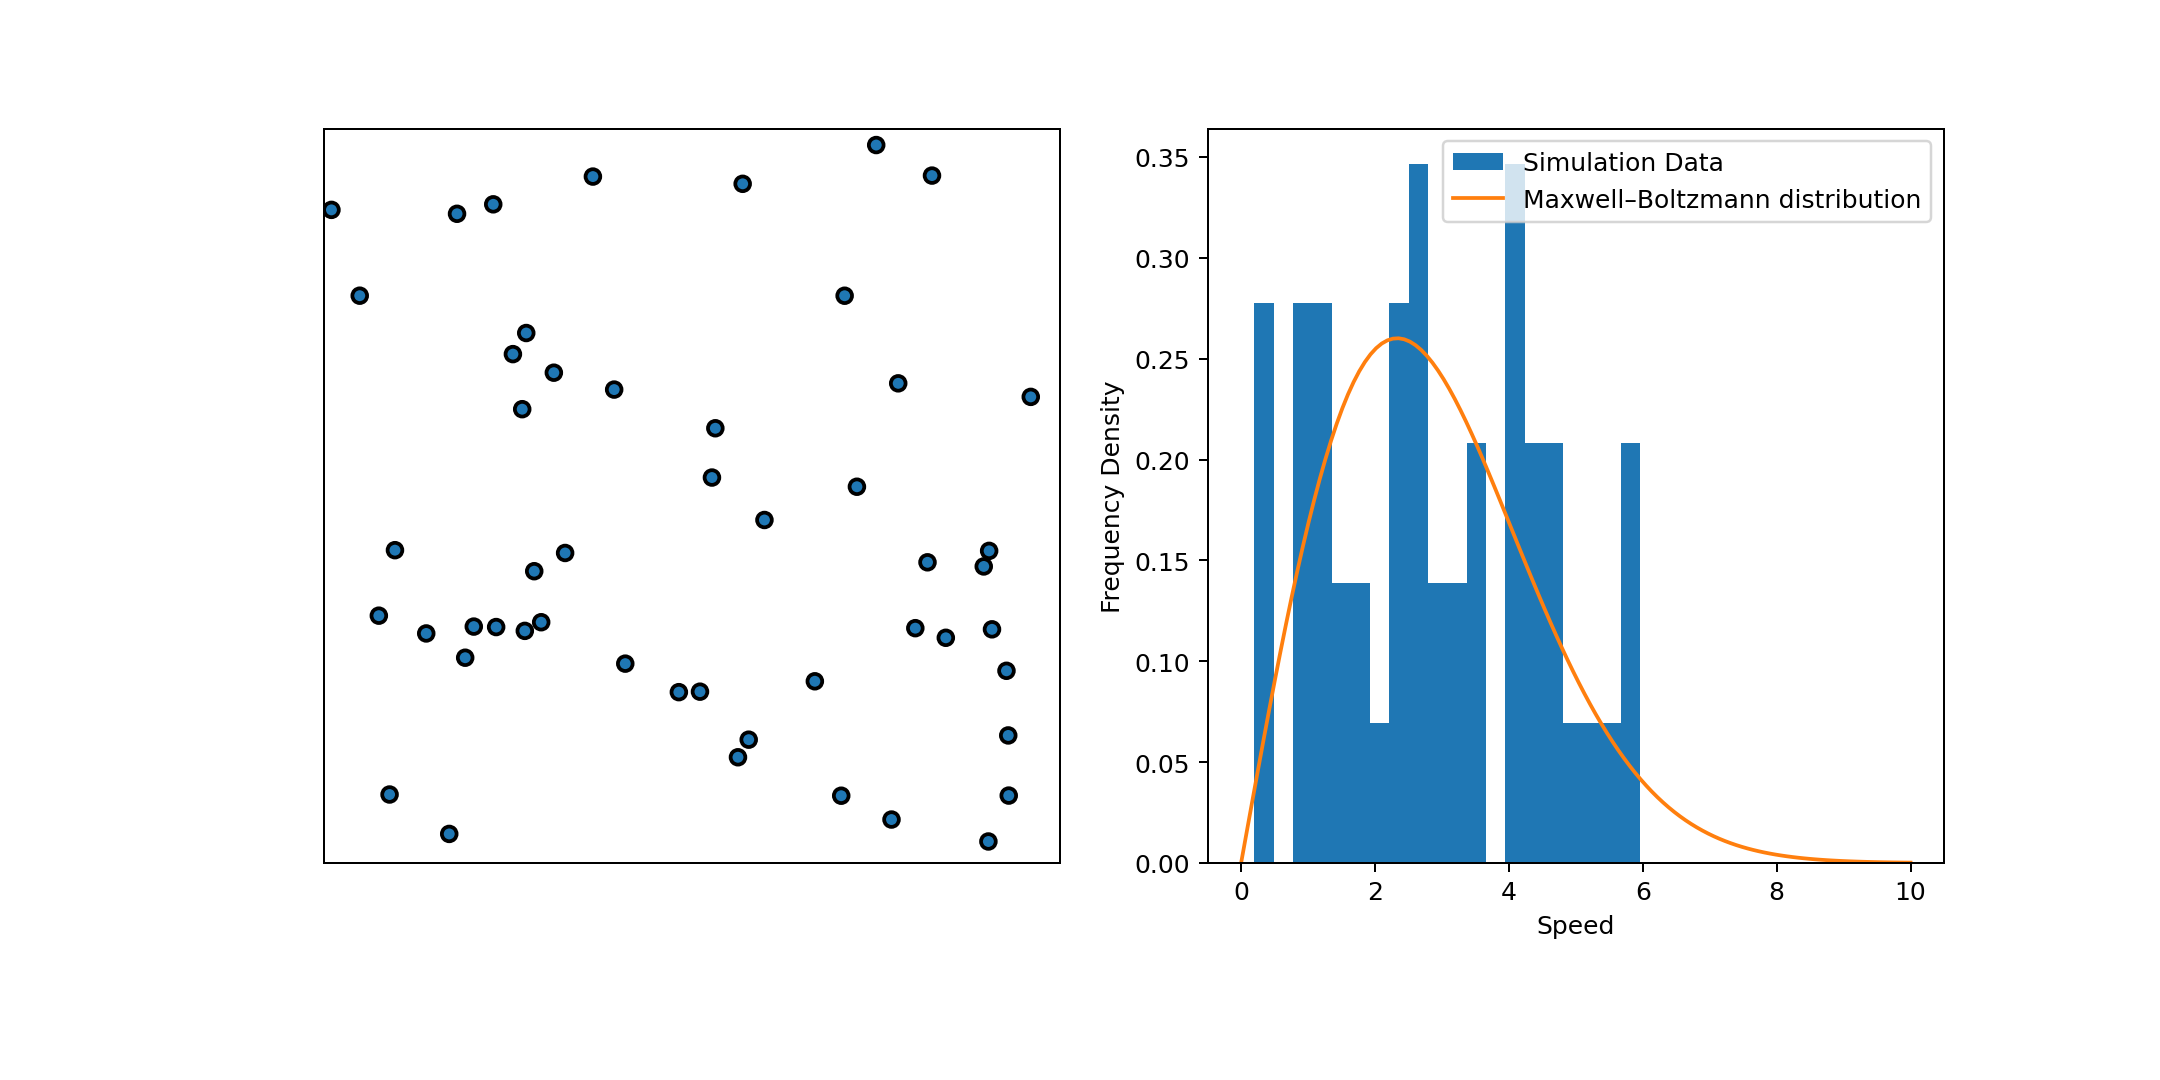

In [4]:
# Visualization of the solution with matplotlib.

import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,2,1)

hist = fig.add_subplot(1,2,2)

plt.subplots_adjust(bottom=0.2,left=0.15)

ax.axis('equal')
ax.axis([-1, 30, -1, 30])

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim([0,boxsize])
ax.set_ylim([0,boxsize])

# Draw Particles as circles
circle = [None]*particle_number
for i in range(particle_number):
    circle[i] = plt.Circle((particle_list[i].solpos[0][0], particle_list[i].solpos[0][1]), particle_list[i].radius, ec="black", lw=1.5, zorder=20)
    ax.add_patch(circle[i])

# Graph Particles speed histogram
vel_mod = [particle_list[i].solvel_mag[0] for i in range(len(particle_list))]
hist.hist(vel_mod, bins= 20, density = True, label = "Simulation Data")
hist.set_xlabel("Speed")
hist.set_ylabel("Frequency Density")



# Compute 2d Boltzmann distribution

#total energy should be constant for any time index
def total_Energy(particle_list, index): 
    return sum([particle_list[i].mass / 2. * particle_list[i].solvel_mag[index]**2  for i in range(len(particle_list))])


E = total_Energy(particle_list, 0)
Average_E = E/len(particle_list) 
k = 1.38064852e-23
T = 2*Average_E/(2*k)
m = particle_list[0].mass
v = np.linspace(0,10,120)
fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
hist.plot(v,fv, label = "Maxwell–Boltzmann distribution") 
hist.legend(loc ="upper right")

# from matplotlib.widgets import Slider

# axtemp = plt.axes([0.2, 0.1, 0.65, 0.03])
# slider_temp = Slider(axtemp, "Temperature(K)", 100, 1100, valinit=100)

# def update(temp):
#     k = np.arange(100,1100,100)
    
#     for j in range(particle_number):
#         circle[j].center = particle_list[j].solpos[i][0], particle_list[j].solpos[i][1]     
#     hist.clear() 
    
#     vel_mod = [particle_list[j].solvel_mag[i] for j in range(len(particle_list))]
#     hist.hist(vel_mod, bins= 20, density = True, label = "Simulation Data")
#     hist.set_xlabel("Speed")
#     hist.set_ylabel("Frequency Density") 
    
#     E = total_Energy(particle_list, i)
#     Average_E = E/len(particle_list) 
#     k = 1.38064852e-23
#     T = 2*Average_E/(2*k)
#     m = particle_list[0].mass
#     v = np.linspace(0,10,120)
#     fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
#     hist.plot(v,fv, label = "Maxwell–Boltzmann distribution") 
#     hist.legend(loc ="upper right") 

from matplotlib.animation import FuncAnimation

def animate(time):
    i = int(np.rint(time/timestep))
    
    #ax.set_title('Energy =' + str(Energy[i]))
    
    # Draw Particles as circles
    for j in range(particle_number):
        circle[j].center = particle_list[j].solpos[i][0], particle_list[j].solpos[i][1]  
        
    hist.clear() 
    # Graph Particles speed histogram
    vel_mod = [particle_list[j].solvel_mag[i] for j in range(len(particle_list))]
    hist.hist(vel_mod, bins= 20, density = True, label = "Simulation Data")
    hist.set_xlabel("Speed")
    hist.set_ylabel("Frequency Density") 
    
    # Compute 2d Boltzmann distribution
    E = total_Energy(particle_list, i)
    Average_E = E/len(particle_list) 
    k = 1.38064852e-23
    T = 2*Average_E/(2*k)
    m = particle_list[0].mass
    v = np.linspace(0,10,120)
    fv = m*np.exp(-m*v**2/(2*T*k))/(2*np.pi*T*k)*2*np.pi*v
    hist.plot(v,fv, label = "Maxwell–Boltzmann distribution") 
    hist.legend(loc ="upper right")

# Uncomment to save as gif    
#ani = FuncAnimation(fig, animate, frames=np.arange(0, 10, 0.1), interval=500, blit=True)
fig.show()